# Definition of the Models

In [44]:
import sklearn
import numpy as np
import pandas as pd
import time
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
import xgboost as xgb
import math 
from yellowbrick.regressor import PredictionError

##### Opening the csv generated by the preprocessing

In [31]:
path='/Users/Pierr/OneDrive/Documents/CentraleSupelec/MLAirBnb/train_airbnb_berlin_Preprocessed.csv'
my_sep,my_encoding=',','utf-8'
df=pd.read_csv(path,sep=my_sep,encoding=my_encoding)

Defining a function in oder to plot the predicted values vs the actual values

In [33]:
def plotGraph(y_test,y_pred,regressorName):
    my_range = int(max(y_pred))
    plt.plot(range(len(y_test)), y_test, color='blue', label="Actual Values")
    plt.plot(range(len(y_pred)), y_pred, color='red', label="Predicted Values")
    plt.legend(loc="upper left")
    plt.title(regressorName)
    plt.show()
    return

##### Creating X and y

In [32]:
X=df.drop(columns=['price'])
y=df['price'].copy()

##### Split X and Y into Train and Validation with Ratios 80:20

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### GridSearch Cross Validation on various models in order to see the score of each and we select the two bests

In [67]:
lr=LinearRegression()
dt=DecisionTreeRegressor()
rf=RandomForestRegressor()
svm=SVR()
xgboost=xgb.XGBRegressor()
adab=AdaBoostRegressor()
class_list=[lr, dt,rf,svm,xgboost,adab]
for model in class_list:
        start = time.time()
        grid = GridSearchCV(estimator=model, param_grid={}, scoring='neg_root_mean_squared_error', cv=3, n_jobs=-1,verbose=3)
        grid.fit(X_train, y_train)
        end = time.time()
        print(model, '\n', -grid.best_score_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
LinearRegression() 
 28.627248963833836
Fitting 3 folds for each of 1 candidates, totalling 3 fits
DecisionTreeRegressor() 
 40.19916901714988
Fitting 3 folds for each of 1 candidates, totalling 3 fits
RandomForestRegressor() 
 28.697268385670004
Fitting 3 folds for each of 1 candidates, totalling 3 fits
SVR() 
 41.057763480487864
Fitting 3 folds for each of 1 candidates, totalling 3 fits
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, gamma=None,
             gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             

**XGBoost**, **Random Forest** and **LinearRegression** are the three best options here, we are going to use a GridSearch for XGBoost and RandomForest.
We chose to keep Linear Regression as this is the easiest model and everyone knows it. With those three models we have three different types and we will see which one is the best.

### Linear Regression

In [35]:
clf_lr = LinearRegression()
clf_lr.fit(X_train,y_train)

y_pred_lr = clf_lr.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred_lr)
mae = metrics.mean_absolute_error(y_test, y_pred_lr)
r2 = metrics.r2_score(y_test, y_pred_lr)
print ('mse = {}, rmse = {} \nmae = {} r2 = {}'.format(mse,math.sqrt(mse), mae, r2))

mse = 819.3711044765262, rmse = 28.62465902812689 
mae = 19.055551440613673 r2 = 0.509380951779685


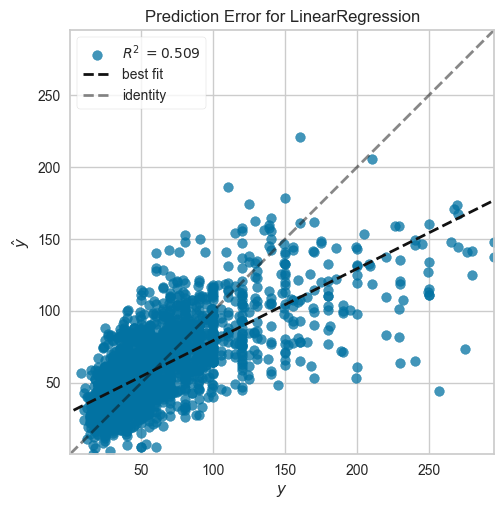

<AxesSubplot: title={'center': 'Prediction Error for LinearRegression'}, xlabel='$y$', ylabel='$\\hat{y}$'>

In [46]:
model = LinearRegression()
visualizer = PredictionError(model)

visualizer.fit(X_train, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test, y_test)  # Evaluate the model on the test data
visualizer.show() 

Plotting the actual values vs the predicted values for Linear Regression

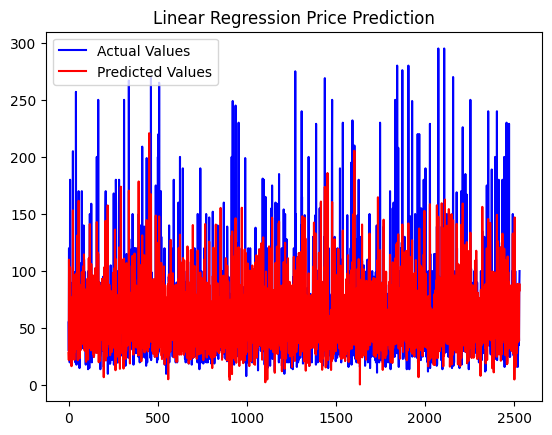

In [36]:
plotGraph(y_test, y_pred_lr, "Linear Regression Price Prediction")

In [ ]:
diff = y_test - y_pred_lr
diff.hist(bins = 40)
plt.title('Histogram of prediction errors')
plt.xlabel('MPG prediction error')
plt.ylabel('Frequency')

### XGBoost

##### Trying different combinations and computations of the hyperparameters with XGBoost to get the best hyperparameters

In [56]:
params = { 'max_depth': [3, 6, 8, 10, 12],
           'learning_rate': [0.0001, 0.001, 0.01, 0.05, 0.1, 0.15],
           'n_estimators': [100, 250, 500, 600, 800, 1000],
           'colsample_bytree': [0.1, 0.2, 0.3]}

xgbr = xgb.XGBRegressor()
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_root_mean_squared_error', 
                   verbose=1)
clf.fit(X_train, y_train)

best_params_xgb = clf.best_params_
score_xgb = clf.best_score_

Fitting 5 folds for each of 540 candidates, totalling 2700 fits


In [57]:
print('Best params: ', best_params_xgb, '\n', 'Best score: ', -score_xgb)

Best params:  {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 6, 'n_estimators': 800} 
 Best score:  27.74921139214033


In [ ]:
df_plot_grid_xgb = pd.DataFrame(clf.cv_results_)
df_plot_grid_xgb

We plot the "mean_test_score" which is the RMSE versus the params used to compute. It gives us this plot where we can easily see the best RMSE score

Text(0, 0.5, 'mean_test_score')

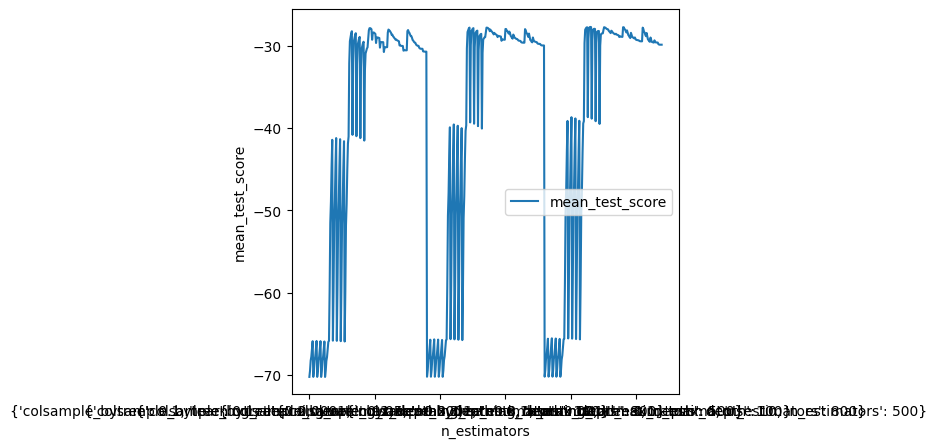

In [59]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()
df_plot_grid_xgb.set_index("params")[["mean_test_score"]].plot(ax=ax)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)
ax.set_xlabel("grid_parameters")
ax.set_ylabel("mean_test_score")

*Now we get to print the MSE, MAE, RMSE and R<sup>2</sup> score*

In [60]:
y_pred = clf.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
print ('mse = {}, rmse = {} \nmae = {} r2 = {}'.format(mse,math.sqrt(mse), mae, r2))

mse = 767.1254444045952, rmse = 27.697029523120257 
mae = 18.26157880545039 r2 = 0.5406643542307745


Now we compute xgb with the best params in order to save time as the GridSearch is quite time and resources consuming

In [6]:
xg_reg = xgb.XGBRegressor(colsample_bytree = 0.3,
                          learning_rate = 0.01,
                          max_depth = 6,
                          n_estimators = 800)

xg_reg.fit(X_train, y_train)
y_pred_xg_reg = xg_reg.predict(X_test)

mse = metrics.mean_squared_error(y_test, y_pred_xg_reg)
mae = metrics.mean_absolute_error(y_test, y_pred_xg_reg)
r2 = metrics.r2_score(y_test, y_pred_xg_reg)
print ('mse = {}, rmse = {} \nmae = {} r2 = {}'.format(mse,math.sqrt(mse), mae, r2))

mse = 766.2831443504984, rmse = 27.681819744202123 
mae = 18.25735191522993 r2 = 0.5411687025640257


Plotting the actual values vs the predicted values for XGBoost

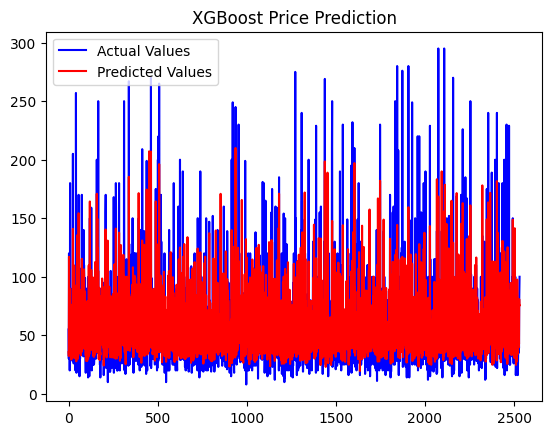

In [7]:
plotGraph(y_test, y_pred_xg_reg, "XGBoost Price Prediction")

### Random Forest

##### Trying Different combinations and computations of the hyperparameters with Random Forest to get the best hyperparameters

In [5]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [30,40],
    'max_features': [90, 180, 200, 230],
    'min_samples_leaf': [3, 4],
    'min_samples_split': [10,12,16],
    'n_estimators': [100,800,1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)
best_params= grid_search.best_params_
score = grid_search.best_score_

print('Best params: ', best_params, '\n', 'Best score: ', -score)

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best params:  {'bootstrap': True, 'max_depth': 40, 'max_features': 90, 'min_samples_leaf': 4, 'min_samples_split': 16, 'n_estimators': 800} 
 Best score:  28.36162020421088


In [16]:
df_plot_grid_rf = pd.DataFrame(grid_search.cv_results_)
df_plot_grid_rf

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,24.206680,0.092177,0.100662,0.005428,True,30,90,3,10,100,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",-28.522444,-28.321790,-28.691935,-28.512056,0.151289,120
1,204.701760,1.441034,0.749974,0.017924,True,30,90,3,10,800,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",-28.424391,-28.223148,-28.528333,-28.391957,0.126684,12
2,255.830148,2.727874,0.957394,0.031373,True,30,90,3,10,1000,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",-28.449502,-28.207135,-28.563512,-28.406716,0.148603,22
3,24.490338,0.532785,0.096658,0.010149,True,30,90,3,12,100,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",-28.473168,-28.341702,-28.466076,-28.426982,0.060371,26
4,203.179098,2.458370,0.717760,0.006914,True,30,90,3,12,800,"{'bootstrap': True, 'max_depth': 30, 'max_feat...",-28.416021,-28.213487,-28.522269,-28.383926,0.128086,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
139,309.080997,4.041406,0.676334,0.010371,True,40,230,4,12,800,"{'bootstrap': True, 'max_depth': 40, 'max_feat...",-28.500442,-28.274656,-28.652695,-28.475931,0.155304,91
140,348.335144,2.073657,0.585335,0.034741,True,40,230,4,12,1000,"{'bootstrap': True, 'max_depth': 40, 'max_feat...",-28.492524,-28.250486,-28.628729,-28.457246,0.156419,54
141,36.699998,0.671758,0.091666,0.008808,True,40,230,4,16,100,"{'bootstrap': True, 'max_depth': 40, 'max_feat...",-28.526714,-28.289858,-28.713603,-28.510058,0.173393,119
142,274.842186,1.841598,0.551333,0.032712,True,40,230,4,16,800,"{'bootstrap': True, 'max_depth': 40, 'max_feat...",-28.485710,-28.260726,-28.633069,-28.459835,0.153106,62


We plot the "mean_test_score" which is the RMSE versus the params used to compute. It gives us this plot where we can easily see the best RMSE score

Text(0, 0.5, 'mean_test_score')

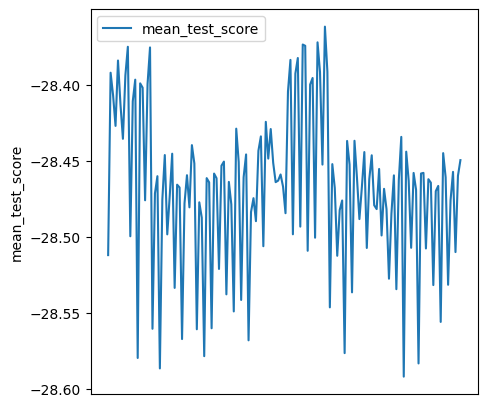

In [23]:
fig = plt.figure(figsize=(5, 5))
ax = plt.subplot()
df_plot_grid_rf.set_index("params")[["mean_test_score"]].plot(ax=ax)
x_axis = ax.axes.get_xaxis()
x_axis.set_visible(False)
ax.set_xlabel("grid_parameters")
ax.set_ylabel("mean_test_score")


*Now we get to print the MSE, MAE, RMSE and R<sup>2</sup> score*

In [8]:
y_pred = grid_search.predict(X_test)
mse = metrics.mean_squared_error(y_test, y_pred)
mae = metrics.mean_absolute_error(y_test, y_pred)
r2 = metrics.r2_score(y_test, y_pred)
print ('mse = {}, rmse = {} \nmae = {} r2 = {}'.format(mse,math.sqrt(mse), mae, r2))

mse = 804.825496216108, rmse = 28.369446526432412 
mae = 18.69819070870873 r2 = 0.5180905004097544


Now we compute Random Forest with the best params in order to save time as the GridSearch is quite time and resources consuming

In [49]:
rf_reg = RandomForestRegressor(bootstrap=True, 
                            max_depth=40,
                            max_features=90,
                            min_samples_leaf=4,
                            min_samples_split=16,
                            n_estimators=800)
rf_reg.fit(X_train, y_train)

rf_reg_pred = rf_reg.predict(X_test)

mse = metrics.mean_squared_error(y_test, rf_reg_pred)
mae = metrics.mean_absolute_error(y_test, rf_reg_pred)
r2 = metrics.r2_score(y_test, rf_reg_pred)
print ('mse = {}, rmse = {} \nmae = {} r2 = {}'.format(mse,math.sqrt(mse), mae, r2))

We plot the actual values vs the predicted values for the Random Forest

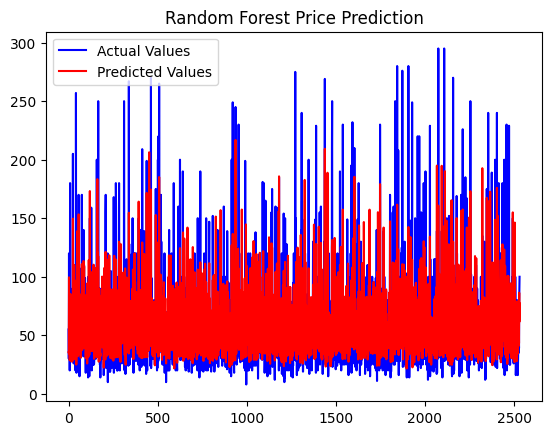

In [82]:
plotGraph(y_test, rf_reg_pred, "Random Forest Price Prediction")

### Exporting the y_pred of XGBoost to CSV

In [10]:
path_predictions=path.split('.')[0]+'_PricePredicted.csv'
sep=','
y_pred_to_csv = pd.DataFrame(y_pred_xg_reg)
y_pred_to_csv.to_csv(path_predictions,sep=sep,index=False)